In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import seaborn as sns

This dataset contains the results of passenger satisfaction surveys on U.S. airlines.

In [4]:
satisfaction = pd.read_csv("passenger_satisfaction.csv",index_col=0).dropna()
satisfaction.head(6)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied


Some of the columns are features that can be deduced independently of surveys, at least in principle. We will separate the two types of features for the analysis that follows.

In [5]:
basic = ['Gender', 'Customer Type', 'Age', 'Class',
        'Flight Distance','Departure Delay in Minutes', 'Arrival Delay in Minutes',]
advanced = ['Type of Travel','Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']
target = 'satisfaction'

## 1
Create a feature frame `X_basic` for just the features in `basic`, using dummy variables to convert the categorical columns. **Use `drop_first=True` when creating dummy variables.**

Make a label series `y` for the *satisfaction* column. 

Split off 20% of the data into a test set, using a shuffle with random state 302.

In [6]:
X_basic = None
y = None

from sklearn.model_selection import train_test_split

X_basic = pd.get_dummies(satisfaction[basic], drop_first=True)
y = satisfaction[target]

X_basic_train, X_basic_test, y_train, y_test = train_test_split(
    X_basic, y, test_size=0.2, random_state=302, shuffle=True
)

In [7]:
print("Basic features:")
X_basic.head(5)

Basic features:


,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Class_Eco,Class_Eco Plus
0,13,460,25,18.0,True,False,False,True
1,25,235,1,6.0,True,True,False,False
2,26,1142,0,0.0,False,False,False,False
3,25,562,11,9.0,False,False,False,False
4,61,214,0,0.0,True,False,False,False


In [8]:
print("labels:")
y.head(5)

labels:


0    neutral or dissatisfied
1    neutral or dissatisfied
2                  satisfied
3    neutral or dissatisfied
4                  satisfied
Name: satisfaction, dtype: object

In [9]:
print(X_basic_train.shape[0], "training samples and", X_basic_test.shape[0], "testing samples")

103589 training samples and 25898 testing samples


In [10]:
### TESTS
assert X_basic.shape[1]==8, "Wrong number of columns"
assert len(y)==129487 and sum(y=="satisfied")==56262, "Incorrect y vector"
assert np.isclose(X_basic_train["Age"].mean(), 39.426937223, atol=1e-3, rtol=1e-3), "Incorrect training subset"

print("OK")

OK


## 2

(5.5) Make a pipeline with a standard column scaler and a logistic regression on the test data with the option `penalty=None`, which disables regularization. 

Train it on the basic features training set and find its score on the test set.

In [12]:
basic_score = None

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
pipeline_basic = make_pipeline(StandardScaler(), LogisticRegression(penalty=None))
pipeline_basic.fit(X_basic_train, y_train)
basic_score = pipeline_basic.score(X_basic_test, y_test)


In [13]:
print(f"Logistic regression for basic features has score {basic_score:.5f}")

Logistic regression for basic features has score 0.75967


In [14]:
### TESTS
assert 0.75 < basic_score < 0.80, "Basic score is wrong"

print("OK")

OK


## 3

(5.5) **Using only the first 1000 members** of the test set, plot the ROC curve for the regressor from step 2 for positive outcome *satisfied*.

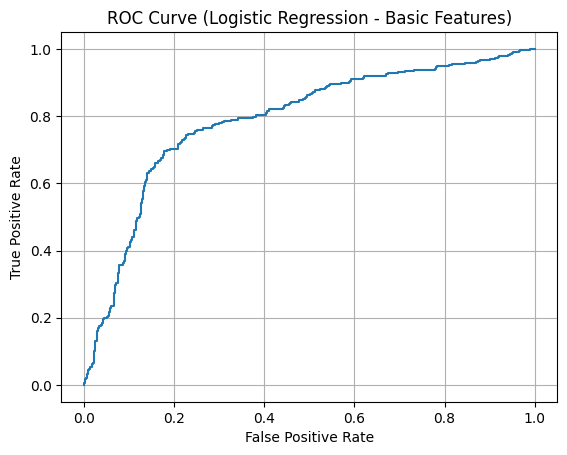

In [15]:
# Result is a plot

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

X_sample = X_basic_test.iloc[:1000]
y_sample = y_test.iloc[:1000]

probs = pipeline_basic.predict_proba(X_sample)[:, 1]
fpr, tpr, _ = roc_curve(y_sample == 'satisfied', probs)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression - Basic Features)")
plt.grid(True)
plt.show()


## 4
(5.5) In the same manner as step 1, make a feature matrix `X` that uses all of the columns in `basic` and `advanced`, converting to dummy variables with `drop_first=True`. Split the dataset into training and testing subsets using random state 302.

As in step 2, train a pipeline using logistic regression but with $C=0.01$, `penalty="l1"`, `solver="liblinear"` (since the default solver won't work with l1), and random state equal to 19716 (since the solver has some randomization). 

Compute the test score of the new pipeline.

In [16]:
X = None
X_train, X_test, y_train, y_test = None, None, None, None
all_score = None, None

X = pd.get_dummies(satisfaction[basic + advanced], drop_first=True)
y = satisfaction[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=302, shuffle=True
)

pipeline_all = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=0.01,
        penalty="l1",
        solver="liblinear",
        random_state=19716
    )
)

pipeline_all.fit(X_train, y_train)
all_score = pipeline_all.score(X_test, y_test)

In [17]:
print(f"Logistic regression for all features has score {all_score:.5f}")

Logistic regression for all features has score 0.87231


In [18]:
### TESTS
assert len(X.columns) == 23, "Wrong number of columns in X"
assert np.isclose( X_train["Age"].mean(), 39.426937223, atol=1e-3, rtol=1e-3), "Incorrect training set"
assert 0.85 < all_score < 0.88

print("OK")

OK


## 5

(5.5) Let `weights` be the series of weights from the regression in step 4, indexed by feature name and sorted in ascending order. 

In [19]:
weights = pd.Series(
    pipeline_all.named_steps['logisticregression'].coef_[0],
    index=X.columns
).sort_values()

In [20]:
print(weights)

Type of Travel_Personal Travel      -1.239466
Customer Type_disloyal Customer     -0.757899
Class_Eco                           -0.346724
Class_Eco Plus                      -0.198629
Departure/Arrival time convenient   -0.192743
Ease of Online booking              -0.179073
Arrival Delay in Minutes            -0.175299
Age                                 -0.106678
Departure Delay in Minutes           0.000000
Flight Distance                      0.000000
Food and drink                       0.000000
Gate location                        0.010791
Gender_Male                          0.013929
Inflight entertainment               0.063773
Seat comfort                         0.079656
Inflight service                     0.141109
Baggage handling                     0.151127
Cleanliness                          0.280845
Leg room service                     0.331644
On-board service                     0.381485
Checkin service                      0.393965
Inflight wifi service             

In [21]:
### TESTS
assert type(weights) == pd.Series
assert np.isclose( weights.mean(), -0.001956998, atol=1e-3, rtol=1e-3 )
assert np.all( np.diff(weights.values) >= 0 )

print("OK")

OK


## 6

What feature contributes the most to customer satisfaction? Which type of traveler is more likely to experience greater satisfaction, a personal traveler or a business traveler? Type your answers into the cell below, and give reasons for your answers. 

Most contributing feature: Online boarding — it has the highest positive weight.

More satisfied traveler type: Business travelers — personal travel has a negative weight, meaning business travelers are more likely to be satisfied.